# ARIMA Using Historical Monthly Oil Prices

In [46]:
! pip install nasdaq-data-link
! pip install pmdarima

In [1]:
import pandas as pd
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima_model import ARIMA
%matplotlib inline
import nasdaqdatalink
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.pyplot import figure
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from numpy import log
from pmdarima.arima.utils import ndiffs
from statsmodels.tsa.stattools import acf
import pmdarima as pm

In [31]:
oil = pd.read_csv("C:/Users/Admin/Desktop/Data Capstone/oilprice_monthly.csv", sep = ";")
oil

,Date,Value
0,Jan-00,27.26
1,Feb-00,29.37
2,Mar-00,29.84
3,Apr-00,25.72
4,May-00,28.79
...,...,...
260,Sep-21,71.65
261,Oct-21,81.48
262,Nov-21,79.15
263,Dec-21,71.71


In [7]:
result = adfuller(oil.Value.dropna())
print("ADF Statistic: %f" % result[0])
print("p-value: %f" % result[1])

ADF Statistic: -2.698627
p-value: 0.074276


Since the P > 0.05 we need to difference the series since it is not initially stationary.

In [33]:
oil_df = pd.DataFrame(oil)

oil_df.Date = pd.to_datetime(oil_df.Date, format = '%b-%y')
oil_df

,Date,Value
0,2000-01-01,27.26
1,2000-02-01,29.37
2,2000-03-01,29.84
3,2000-04-01,25.72
4,2000-05-01,28.79
...,...,...
260,2021-09-01,71.65
261,2021-10-01,81.48
262,2021-11-01,79.15
263,2021-12-01,71.71


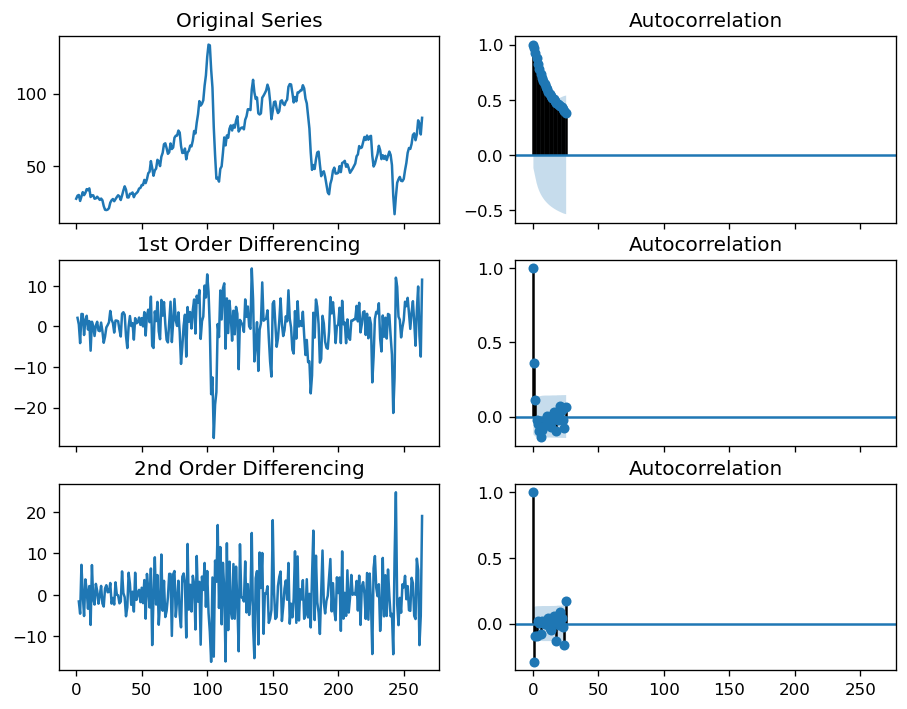

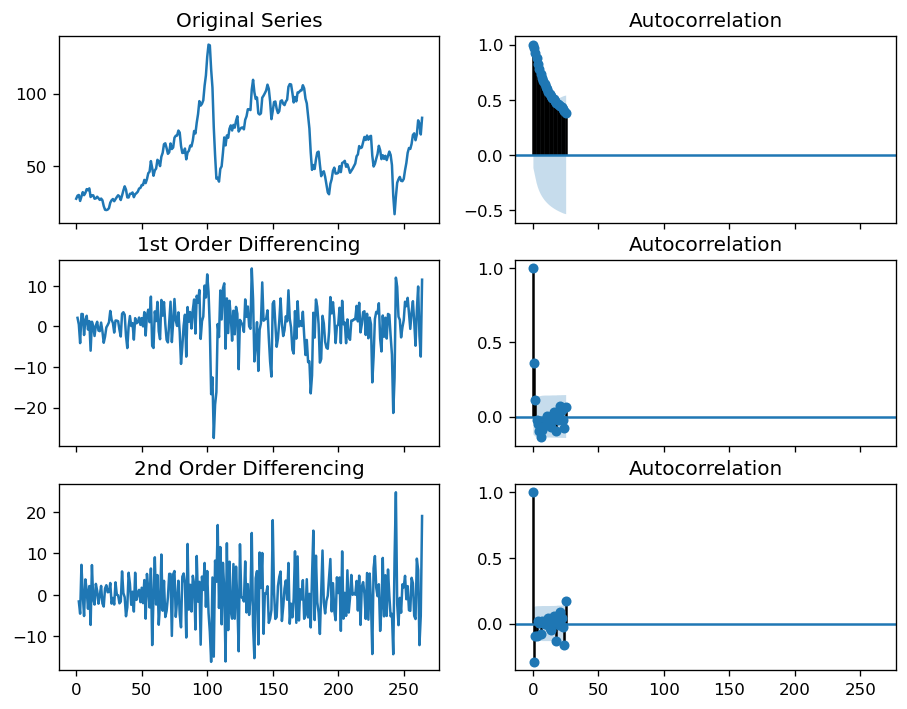

In [34]:
plt.rcParams.update({'figure.figsize':(9,7), 'figure.dpi':120})

# Differencing
fig, axes = plt.subplots(3, 2, sharex=True)
axes[0, 0].plot(oil_df.Value); axes[0, 0].set_title('Original Series')
plot_acf(oil_df.Value, ax=axes[0, 1])

# 1st Differencing
axes[1, 0].plot(oil_df.Value.diff()); axes[1, 0].set_title('1st Order Differencing')
plot_acf(oil_df.Value.diff().dropna(), ax=axes[1, 1])

# 2nd Differencing
axes[2, 0].plot(oil_df.Value.diff().diff()); axes[2, 0].set_title('2nd Order Differencing')
plot_acf(oil_df.Value.diff().diff().dropna(), ax=axes[2, 1])

The series reaches stationarity after two orders of differencing but we will take order of differencing as 1 since the second one goes in to negative

In [35]:
y = oil_df.Value

In [36]:
## Adf Test
ndiffs(y, test='adf')  # 1

1

In [37]:
# KPSS test
ndiffs(y, test='kpss')  # 1

1

In [38]:
# PP test
ndiffs(y, test='pp')  # 1

1

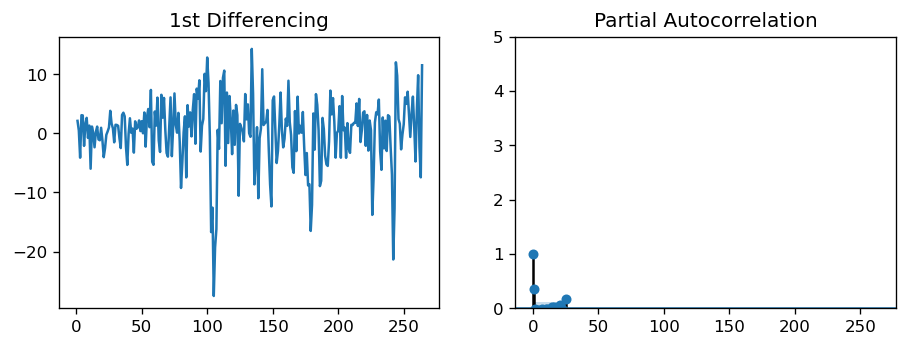

In [39]:
# PACF plot of 1st differenced series
plt.rcParams.update({'figure.figsize':(9,3), 'figure.dpi':120})

fig, axes = plt.subplots(1, 2, sharex=True)
axes[0].plot(oil_df.Value.diff()); axes[0].set_title('1st Differencing')
axes[1].set(ylim=(0,5))
plot_pacf(oil_df.Value.diff().dropna(), ax=axes[1])

plt.show()

We will fix, or the AR term as p = 1

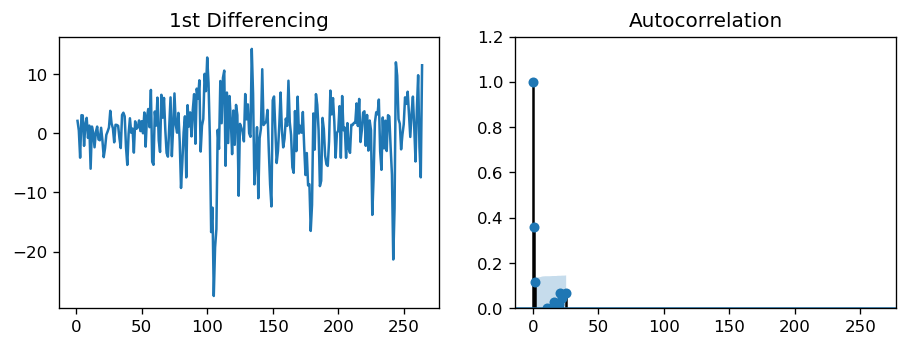

In [40]:
plt.rcParams.update({'figure.figsize':(9,3), 'figure.dpi':120})

fig, axes = plt.subplots(1, 2, sharex=True)
axes[0].plot(oil_df.Value.diff()); axes[0].set_title('1st Differencing')
axes[1].set(ylim=(0,1.2))
plot_acf(oil_df.Value.diff().dropna(), ax=axes[1])

plt.show()

We will take the MA order to be q = 1 since only the first lagg exceeds the blue area

In [41]:
# 2,2,2 ARIMA

model = ARIMA(oil_df.Value, order=(2,2,2))
model_fit = model.fit(disp=0)
print(model_fit.summary())

                             ARIMA Model Results                              
Dep. Variable:               D2.Value   No. Observations:                  263
Model:                 ARIMA(2, 2, 2)   Log Likelihood                -812.576
Method:                       css-mle   S.D. of innovations              5.267
Date:                Tue, 03 May 2022   AIC                           1637.153
Time:                        15:27:37   BIC                           1658.586
Sample:                             2   HQIC                          1645.766
                                                                              
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const             -0.0005      0.007     -0.077      0.938      -0.014       0.013
ar.L1.D2.Value    -0.5966      0.073     -8.136      0.000      -0.740      -0.453
ar.L2.D2.Value     0.3476      0.063

In [42]:
# 1,2,1 ARIMA

model = ARIMA(oil_df.Value, order=(1,2,1))
model_fit = model.fit(disp=0)
print(model_fit.summary())

                             ARIMA Model Results                              
Dep. Variable:               D2.Value   No. Observations:                  263
Model:                 ARIMA(1, 2, 1)   Log Likelihood                -812.841
Method:                       css-mle   S.D. of innovations              5.273
Date:                Tue, 03 May 2022   AIC                           1633.682
Time:                        15:27:40   BIC                           1647.971
Sample:                             2   HQIC                          1639.425
                                                                              
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const             -0.0005      0.007     -0.079      0.937      -0.014       0.013
ar.L1.D2.Value     0.3694      0.058      6.366      0.000       0.256       0.483
ma.L1.D2.Value    -1.0000      0.010

The second ARIMA model we created is far better since the MA1 and AR1 P>|z| values are signifficant, i.e., less than 0.05

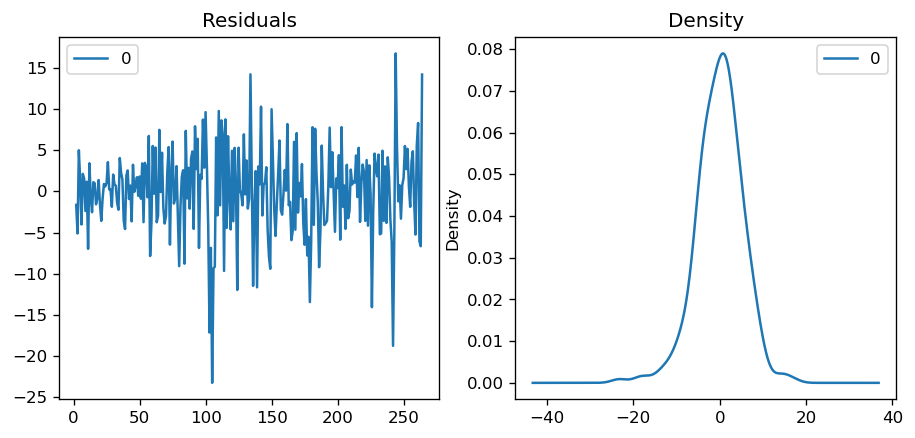

In [43]:
plt.rcParams.update({'figure.figsize':(9,4), 'figure.dpi':120})

residuals = pd.DataFrame(model_fit.resid)
fig, ax = plt.subplots(1,2)
residuals.plot(title="Residuals", ax=ax[0])
residuals.plot(kind='kde', title='Density', ax=ax[1])
plt.show()

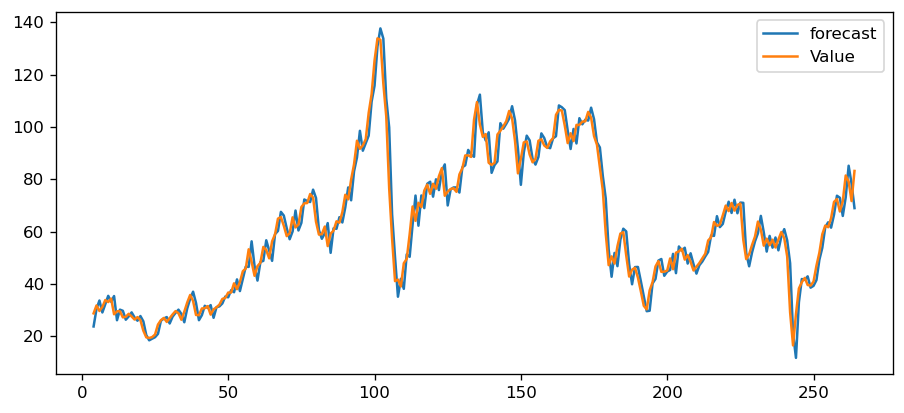

In [44]:
model_fit.plot_predict(dynamic=False)
plt.show()

# Out-of-Time Cross Validation

In [45]:
# Create Training and Test
train = oil_df.Value[:200]
test = oil_df.Value[200:]

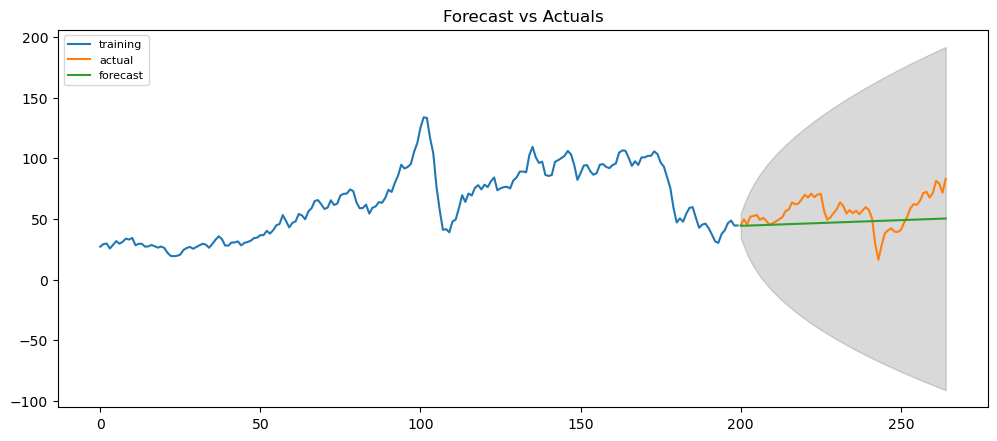

In [46]:
# Build Model
 
model = ARIMA(train, order=(2, 1, 1))  
fitted = model.fit(disp=-1)  

# Forecast
fc, se, conf = fitted.forecast(65, alpha=0.05)  # 95% conf

# Make as pandas series
fc_series = pd.Series(fc, index=test.index)
lower_series = pd.Series(conf[:, 0], index=test.index)
upper_series = pd.Series(conf[:, 1], index=test.index)

# Plot
plt.figure(figsize=(12,5), dpi=100)
plt.plot(train, label='training')
plt.plot(test, label='actual')
plt.plot(fc_series, label='forecast')
plt.fill_between(lower_series.index, lower_series, upper_series, 
                 color='k', alpha=.15)
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()

In [47]:
# Accuracy metrics
def forecast_accuracy(forecast, actual):
    mape = np.mean(np.abs(forecast - actual)/np.abs(actual))  # MAPE
    me = np.mean(forecast - actual)             # ME
    mae = np.mean(np.abs(forecast - actual))    # MAE
    mpe = np.mean((forecast - actual)/actual)   # MPE
    rmse = np.mean((forecast - actual)**2)**.5  # RMSE
    corr = np.corrcoef(forecast, actual)[0,1]   # corr
    mins = np.amin(np.hstack([forecast[:,None], 
                              actual[:,None]]), axis=1)
    maxs = np.amax(np.hstack([forecast[:,None], 
                              actual[:,None]]), axis=1)
    minmax = 1 - np.mean(mins/maxs)             # minmax
    acf1 = acf(fc-test)[1]                      # ACF1
    return({'mape':mape, 'me':me, 'mae': mae, 
            'mpe': mpe, 'rmse':rmse, 'acf1':acf1, 
            'corr':corr, 'minmax':minmax})

forecast_accuracy(fc, test.values)

D:\Anaconda\lib\site-packages\statsmodels\tsa\stattools.py:568: FutureWarning: fft=True will become the default in a future version of statsmodels. To suppress this warning, explicitly set fft=False.
  warnings.warn(


{'mape': 0.23300099594119547,
 'me': -8.517354219850574,
 'mae': 12.372359674081883,
 'mpe': -0.09050066000183148,
 'rmse': 14.926941873524063,
 'acf1': 0.8611635873692463,
 'corr': 0.22015934299347967,
 'minmax': 0.20137512760939524}

# Auto ARIMA

In [49]:
model = pm.auto_arima(oil_df.Value, start_p=1, start_q=1,
                      test='adf',       # use adftest to find optimal 'd'
                      max_p=3, max_q=3, # maximum p and q
                      m=1,              # frequency of series
                      d=None,           # let model determine 'd'
                      seasonal=False,   # No Seasonality
                      start_P=0, 
                      D=1, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)

print(model.summary())

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=1634.070, Time=0.05 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=1667.301, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=1632.184, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=1636.222, Time=0.04 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=1665.673, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=1634.028, Time=0.07 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=1630.675, Time=0.30 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=1632.394, Time=0.33 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=1632.407, Time=0.26 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=1635.071, Time=0.11 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=1634.885, Time=0.10 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=1634.271, Time=0.53 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=1629.271, Time=0.15 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=1632.300, Time=0.02 sec
 ARIMA(2,1,0)(0,0,0)[0]          

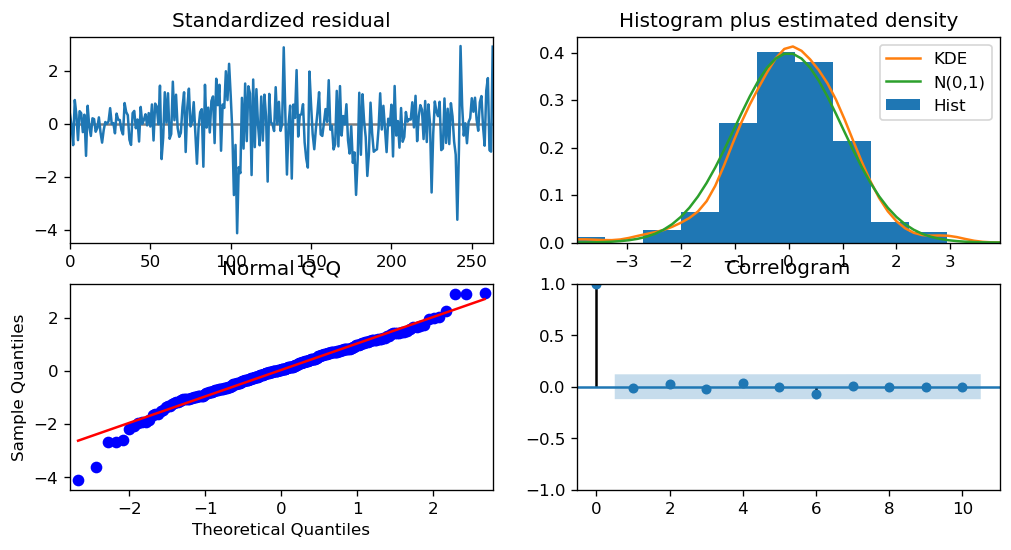

In [50]:
model.plot_diagnostics(figsize=(10,5))
plt.show()

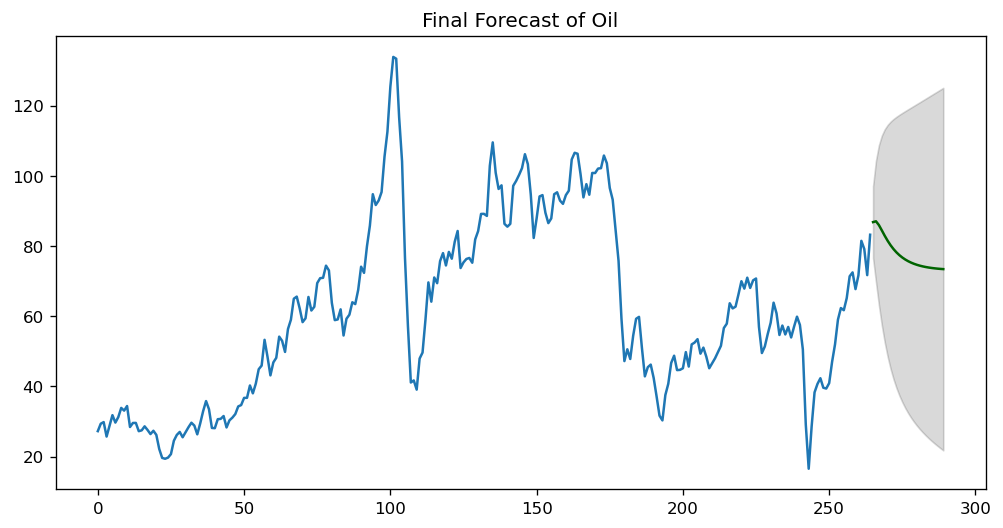

In [51]:
plt.rcParams.update({'figure.figsize':(10,5), 'figure.dpi':120})


# Forecast
n_periods = 25
fc, confint = model.predict(n_periods=n_periods, return_conf_int=True)
index_of_fc = np.arange(len(oil_df.Value), len(oil_df.Value)+n_periods)

# make series for plotting purpose
fc_series = pd.Series(fc, index=index_of_fc)
lower_series = pd.Series(confint[:, 0], index=index_of_fc)
upper_series = pd.Series(confint[:, 1], index=index_of_fc)

# Plot
plt.plot(oil_df.Value)
plt.plot(fc_series, color='darkgreen')
plt.fill_between(lower_series.index, 
                 lower_series, 
                 upper_series, 
                 color='k', alpha=.15)
plt.title("Final Forecast of Oil")
plt.show()

# SARIMA

In [4]:
oil_df = pd.read_csv("C:/Users/Admin/Desktop/Data Capstone/oilprice_monthly.csv", sep = ";", parse_dates=['Date'], index_col='Date')
oil_df

,Value
Date,
Jan-00,27.26
Feb-00,29.37
Mar-00,29.84
Apr-00,25.72
May-00,28.79
...,...
Sep-21,71.65
Oct-21,81.48
Nov-21,79.15


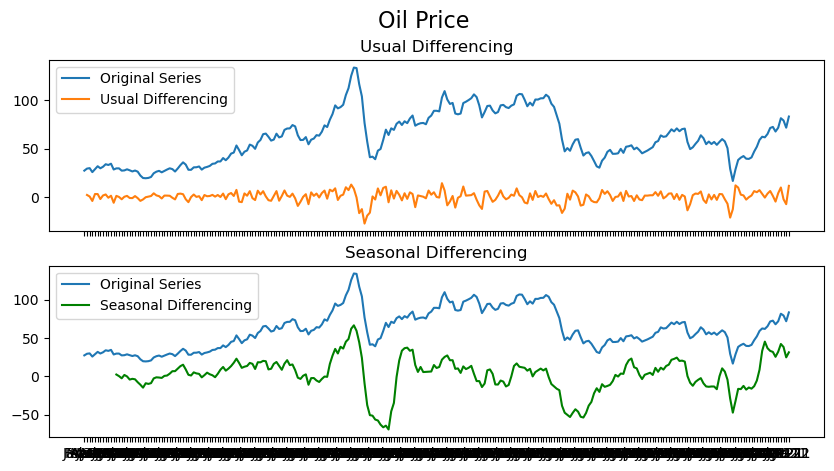

In [5]:
# Plot
fig, axes = plt.subplots(2, 1, figsize=(10,5), dpi=100, sharex=True)

# Usual Differencing
axes[0].plot(oil_df.Value[:], label='Original Series')
axes[0].plot(oil_df.Value[:].diff(1), label='Usual Differencing')
axes[0].set_title('Usual Differencing')
axes[0].legend(loc='upper left', fontsize=10)


# Seasinal Dei
axes[1].plot(oil_df.Value[:], label='Original Series')
axes[1].plot(oil_df.Value[:].diff(12), label='Seasonal Differencing', color='green')
axes[1].set_title('Seasonal Differencing')
plt.legend(loc='upper left', fontsize=10)
plt.suptitle('Oil Price', fontsize=16)
plt.show()

In [6]:
# Seasonal - fit stepwise auto-ARIMA
smodel = pm.auto_arima(oil_df.Value, start_p=1, start_q=1,
                         test='adf',
                         max_p=3, max_q=3, m=12,
                         start_P=0, seasonal=True,
                         d=None, D=1, trace=True,
                         error_action='ignore',  
                         suppress_warnings=True, 
                         stepwise=True)

smodel.summary()

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,1,1)[12] intercept   : AIC=inf, Time=1.38 sec
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=2307.392, Time=0.02 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=1717.733, Time=0.29 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=2006.787, Time=0.77 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=2307.140, Time=0.02 sec
 ARIMA(1,0,0)(0,1,0)[12] intercept   : AIC=1773.866, Time=0.05 sec
 ARIMA(1,0,0)(2,1,0)[12] intercept   : AIC=1692.899, Time=1.02 sec
 ARIMA(1,0,0)(2,1,1)[12] intercept   : AIC=inf, Time=3.05 sec
 ARIMA(1,0,0)(1,1,1)[12] intercept   : AIC=inf, Time=1.16 sec
 ARIMA(0,0,0)(2,1,0)[12] intercept   : AIC=2279.064, Time=0.79 sec
 ARIMA(2,0,0)(2,1,0)[12] intercept   : AIC=1649.289, Time=1.13 sec
 ARIMA(2,0,0)(1,1,0)[12] intercept   : AIC=1678.737, Time=0.37 sec
 ARIMA(2,0,0)(2,1,1)[12] intercept   : AIC=inf, Time=3.06 sec
 ARIMA(2,0,0)(1,1,1)[12] intercept   : AIC=inf, Time=1.44 sec
 ARIMA(3,0,0)(2,1,0)[12] intercept   : AIC=1

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                  265
Model:             SARIMAX(2, 0, 0)x(2, 1, 0, 12)   Log Likelihood                -818.881
Date:                            Tue, 10 May 2022   AIC                           1647.762
Time:                                    12:20:52   BIC                           1665.429
Sample:                                         0   HQIC                          1654.870
                                            - 265                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.3502      0.048     28.379      0.000       1.257       1.443
ar.L2         -0.4140      0.048     -8.685      0.000      -0.507      -0.321
ar.S.L12      -0.5474      0.056     -9.747      0.000      -0.657      -0.437
ar.S.L24      -0.3597      0.064     -5.626      0.000      -0.485      -0.234
sigma2        36.7428      2.907     12.638      0.000      31.044      42.441
===================================================================================
Ljung-Box (Q):                       47.26   Jarque-Bera (JB):                 6.54
Prob(Q):                              0.20   Prob(JB):                         0.04
Heteroskedasticity (H):               1.93   Skew:                            -0.07
Prob(H) (two-sided):                  0.00   Kurtosis:                         3.77
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Best model should be SARIMAX(2, 0, 0)x(2, 1, 0, 12)

In [77]:
pd.to_datetime(fitted_series.index)

DatetimeIndex(['2022-01-01', '2022-02-01', '2022-03-01', '2022-04-01',
               '2022-05-01', '2022-06-01', '2022-07-01', '2022-08-01',
               '2022-09-01', '2022-10-01', '2022-11-01', '2022-12-01',
               '2023-01-01', '2023-02-01', '2023-03-01', '2023-04-01',
               '2023-05-01', '2023-06-01', '2023-07-01', '2023-08-01',
               '2023-09-01', '2023-10-01', '2023-11-01', '2023-12-01'],
              dtype='datetime64[ns]', freq='MS')

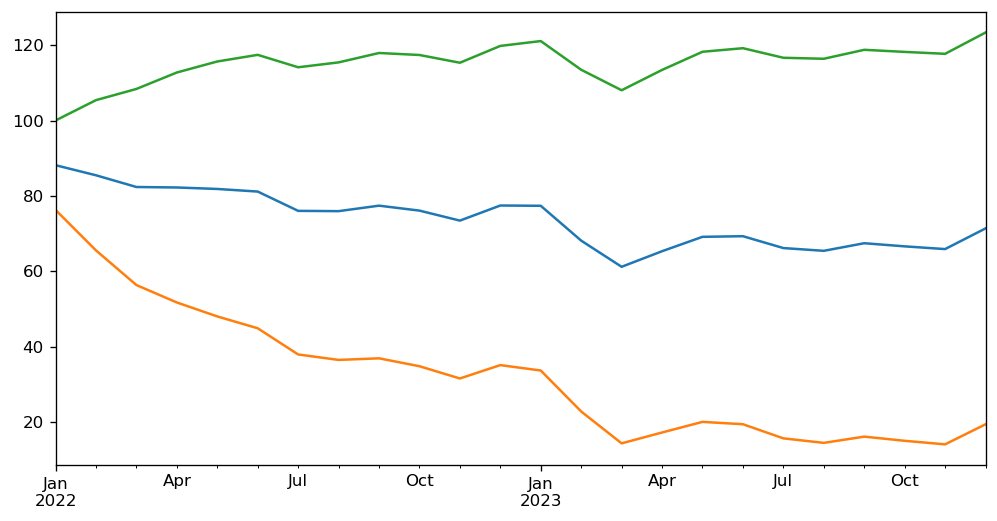

In [82]:
# Forecast
n_periods = 24
fitted, confint = smodel.predict(n_periods=n_periods, return_conf_int=True)
index_of_fc = pd.date_range(oil_df.Date.values[-1], periods = n_periods, freq='MS')

# make series for plotting purpose
fitted_series = pd.Series(fitted, index=index_of_fc)
lower_series = pd.Series(confint[:, 0], index=index_of_fc)
upper_series = pd.Series(confint[:, 1], index=index_of_fc)

# Plot
#plt.plot(oil_df.Value)
#plt.plot(pd.to_datetime(fitted_series.index), fitted_series.values, color='darkgreen')
#plt.fill_between(lower_series.index, 
#                 lower_series, 
 #                upper_series, 
 #                color='k', alpha=.15)

#plt.title("SARIMA - Final Forecast")
fitted_series.plot()
lower_series.plot()
upper_series.plot()
